# Northwestern County 1st Time Home Buyer Analysis

Author: Armun Shakeri

# Overview

This project analyzes homes available in today's housing market and examines which of those homes would be appropriate for a first time home buyer. Also what factors are most important for a first time home buyer to look at. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to buy their first home,  there are many factors that might raise the price of that home. This project analyzes these factors and explores whether they have a positive or negative affect on price. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
# We will remove id since we will be making general recommendations 
kc = kc.drop(['id', 'date', 'sqft_living15', 'sqft_lot15', 'yr_built', 'long', 'floors', 'condition', 
              'sqft_above', 'sqft_lot', 'waterfront', 'yr_renovated', 'view', 'zipcode'], axis=1)
kc.head()

,price,bedrooms,bathrooms,sqft_living,grade,sqft_basement,lat
0,221900.0,3,1.00,1180,7 Average,0.0,47.5112
1,538000.0,3,2.25,2570,7 Average,400.0,47.7210
2,180000.0,2,1.00,770,6 Low Average,0.0,47.7379
3,604000.0,4,3.00,1960,7 Average,910.0,47.5208
4,510000.0,3,2.00,1680,8 Good,0.0,47.6168


In [5]:
# Here we drop all Na values. 
kc=kc.dropna()

In [6]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000][kc.bedrooms<=10]
kc.head()

<ipython-input-6-4f7939aed66f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kc = kc[kc.price<=1000000][kc.bedrooms<=10]


,price,bedrooms,bathrooms,sqft_living,grade,sqft_basement,lat
0,221900.0,3,1.00,1180,7 Average,0.0,47.5112
1,538000.0,3,2.25,2570,7 Average,400.0,47.7210
2,180000.0,2,1.00,770,6 Low Average,0.0,47.7379
3,604000.0,4,3.00,1960,7 Average,910.0,47.5208
4,510000.0,3,2.00,1680,8 Good,0.0,47.6168


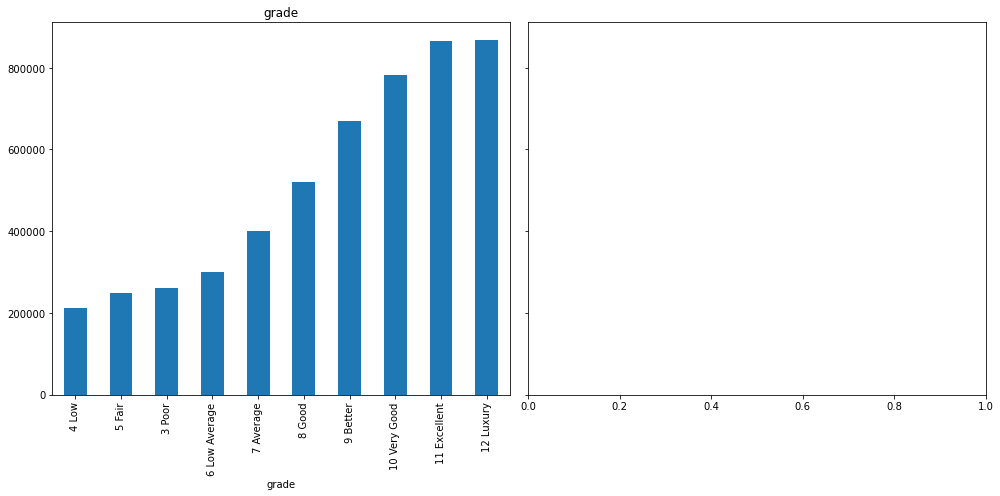

In [7]:
# plotting categorical values vs. price. This shows us all values within categoricals, which values have more
# items and how many categorival values there are. 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7), sharey=True)

categoricals = ['grade']

for col, ax in zip(categoricals, axes.flatten()):
    (kc.groupby(col)
       .mean()['price']            # take the mean of price for each group
       .sort_values()              # sort the groups in ascending order
       .plot
       .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)              # make the title the name of the column
    
fig.tight_layout()

In [8]:
# create dummy variables for categoricals (waterfront, condition and grade)

dummies = pd.get_dummies(kc[categoricals], prefix=categoricals, drop_first=True)     #create dummies and get rid of multicollinearity

kc = kc.drop(categoricals, axis=1)

kc = pd.concat([kc, dummies], axis=1)

kc.head()

,price,bedrooms,bathrooms,sqft_living,sqft_basement,lat,grade_11 Excellent,grade_12 Luxury,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,221900.0,3,1.00,1180,0.0,47.5112,0,0,0,0,0,0,1,0,0
1,538000.0,3,2.25,2570,400.0,47.7210,0,0,0,0,0,0,1,0,0
2,180000.0,2,1.00,770,0.0,47.7379,0,0,0,0,0,1,0,0,0
3,604000.0,4,3.00,1960,910.0,47.5208,0,0,0,0,0,0,1,0,0
4,510000.0,3,2.00,1680,0.0,47.6168,0,0,0,0,0,0,0,1,0


In [9]:
# Build correlation matrix
corr = kc.corr()
corr

,price,bedrooms,bathrooms,sqft_living,lat,grade_11 Excellent,grade_12 Luxury,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
price,1.000000,0.294976,0.439504,0.604233,0.440473,0.136924,0.020265,-0.007387,-0.047730,-0.123166,-0.286368,-0.307585,0.167157,0.363530
bedrooms,0.294976,1.000000,0.502797,0.604490,-0.037402,0.055566,0.013338,-0.018560,-0.071863,-0.116694,-0.241703,-0.069346,0.108768,0.163376
bathrooms,0.439504,0.502797,1.000000,0.711397,-0.017073,0.103674,0.043785,-0.012936,-0.059047,-0.145345,-0.379786,-0.268447,0.277797,0.294854
sqft_living,0.604233,0.604490,0.711397,1.000000,0.000587,0.166648,0.053688,-0.013392,-0.061833,-0.141939,-0.339310,-0.318204,0.176764,0.394299
lat,0.440473,-0.037402,-0.017073,0.000587,1.000000,0.013578,-0.009142,-0.017298,-0.015461,-0.043962,-0.054520,-0.017203,0.036849,0.027346
grade_11 Excellent,0.136924,0.055566,0.103674,0.166648,0.013578,1.000000,-0.000675,-0.000477,-0.002482,-0.007472,-0.022702,-0.060590,-0.043471,-0.023871
grade_12 Luxury,0.020265,0.013338,0.043785,0.053688,-0.009142,-0.000675,1.000000,-0.000070,-0.000365,-0.001099,-0.003340,-0.008914,-0.006395,-0.003512
grade_3 Poor,-0.007387,-0.018560,-0.012936,-0.013392,-0.017298,-0.000477,-0.000070,1.000000,-0.000258,-0.000777,-0.002362,-0.006303,-0.004522,-0.002483
grade_4 Low,-0.047730,-0.071863,-0.059047,-0.061833,-0.015461,-0.002482,-0.000365,-0.000258,1.000000,-0.004041,-0.012279,-0.032771,-0.023512,-0.012911
grade_5 Fair,-0.123166,-0.116694,-0.145345,-0.141939,-0.043962,-0.007472,-0.001099,-0.000777,-0.004041,1.000000,-0.036959,-0.098639,-0.070769,-0.038861


In [10]:
# remove spacing in grade column to help with baseline model 

kc.columns = [grade.replace(' ', '') for grade in kc.columns]

# Data Modeling

In [11]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

,price,bedrooms,bathrooms,sqft_living,lat,grade_11Excellent,grade_12Luxury,grade_3Poor,grade_4Low,grade_5Fair,grade_6LowAverage,grade_7Average,grade_8Good,grade_9Better
count,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000
mean,467959.730744,3.320753,2.039269,1955.546854,47.555948,0.004569,0.000099,0.000050,0.001341,0.012018,0.100958,0.444406,0.291652,0.110443
std,196500.701772,0.881183,0.702399,755.455700,0.141673,0.067439,0.009966,0.007047,0.036593,0.108967,0.301281,0.496912,0.454534,0.313449
min,78000.000000,1.000000,0.500000,370.000000,47.155900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,314500.000000,3.000000,1.500000,1390.000000,47.457600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435000.000000,3.000000,2.000000,1840.000000,47.565800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,594000.000000,4.000000,2.500000,2410.000000,47.680100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1000000.000000,10.000000,7.500000,7480.000000,47.777600,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


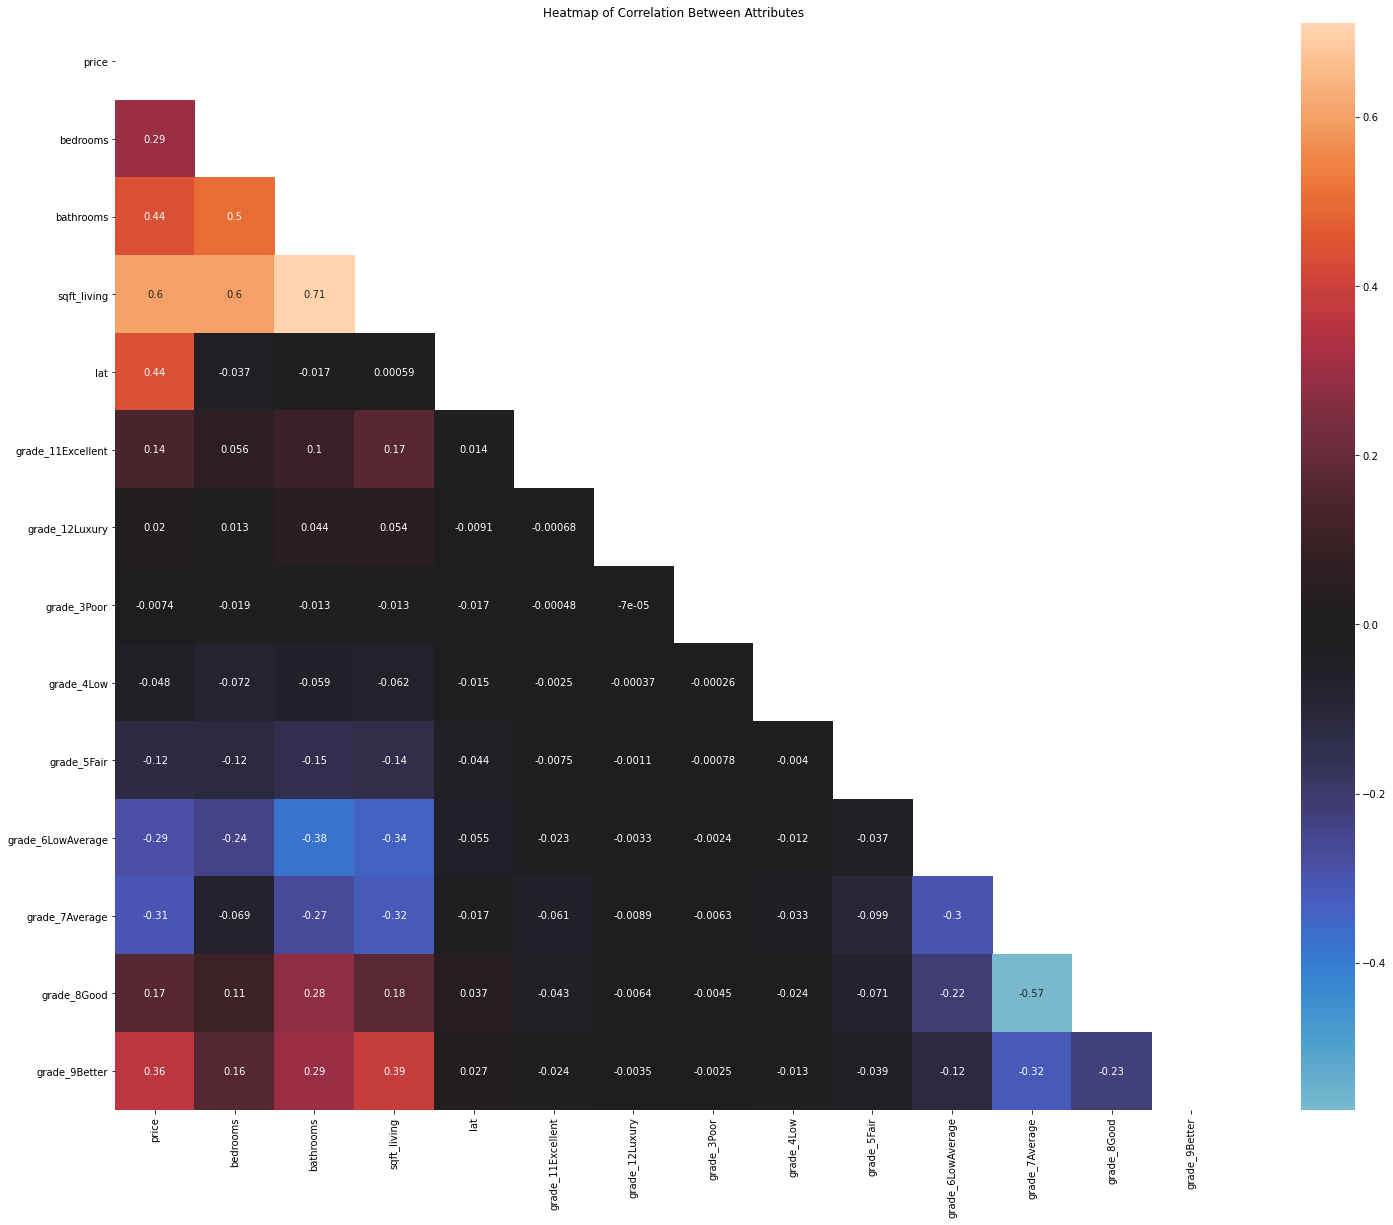

In [12]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living x bathrooms
# 2) price x sqft_living
# 3) price x bathrooms

In [13]:
# Build Baseline Model, incorporated majority of variables to help bring R^2 above .65
# Model displays low R-squared value, will need to add more values to raise R-squared
b = 'price~bedrooms+bathrooms+sqft_living'

model = ols(formula=b, data=kc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     4001.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:47:02   Log-Likelihood:            -2.6930e+05
No. Observations:               20137   AIC:                         5.386e+05
Df Residuals:                   20133   BIC:                         5.386e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.028e+05   4479.643     45.265      0.000    1.94e+05    2.12e+05
bedrooms    -2.563e+04   1574.881    -16.273      0.000   -2.87e+04   -2.25e+04
bathrooms     1.02e+04   2239.500      4.557      0.000    5815.312    1.46e+04
sqft_living   168.4867      2.259     74.571      0.000     164.058     172.915
==============================================================================
Omnibus:                      775.625   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              867.988
Skew:                           0.508   Prob(JB):                    3.30e-189
Kurtosis:                       3.062   Cond. No.                     8.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# After adding lat and grade R-squared now has a value of .615

b = 'price~bedrooms+bathrooms+sqft_living+lat+grade_11Excellent+grade_12Luxury+grade_3Poor+grade_4Low+grade_5Fair+grade_6LowAverage+grade_7Average+grade_8Good'

model = ols(formula=b, data=kc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     2682.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:47:02   Log-Likelihood:            -2.6439e+05
No. Observations:               20137   AIC:                         5.288e+05
Df Residuals:                   20124   BIC:                         5.289e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.706e+07   2.91e+05    -92.858      0.000   -2.76e+07   -2.65e+07
bedrooms          -6085.4856   1275.033     -4.773      0.000   -8584.654   -3586.317
bathrooms         -7628.5903   1853.886     -4.115      0.000   -1.13e+04   -3994.822
sqft_living         108.9374      2.073     52.551      0.000     104.874     113.001
lat                5.777e+05   6114.721     94.476      0.000    5.66e+05     5.9e+05
grade_11Excellent  6.732e+04    1.3e+04      5.179      0.000    4.18e+04    9.28e+04
grade_12Luxury    -6.157e+04   8.64e+04     -0.712      0.476   -2.31e+05    1.08e+05
grade_3Poor        3774.5393   1.22e+05      0.031      0.975   -2.35e+05    2.43e+05
grade_4Low        -2.253e+05   2.39e+04     -9.438      0.000   -2.72e+05   -1.79e+05
grade_5Fair       -2.172e+05   8803.942    -24.673      0.000   -2.34e+05      -2e+05
grade_6LowAverage -2.048e+05   4623.249    -44.297      0.000   -2.14e+05   -1.96e+05
grade_7Average    -1.623e+05   3364.266    -48.252      0.000   -1.69e+05   -1.56e+05
grade_8Good       -9.654e+04   3048.458    -31.667      0.000   -1.03e+05   -9.06e+04
==============================================================================
Omnibus:                     1965.906   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3026.105
Skew:                           0.734   Prob(JB):                         0.00
Kurtosis:                       4.204   Cond. No.                     7.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

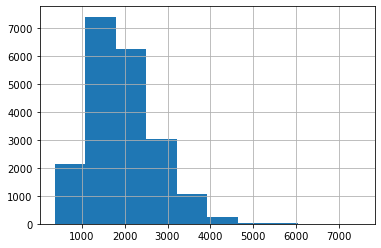

In [15]:
# Model 1
# sqft_living seems fairly normally distributed, slight skew to the left

kc['sqft_living'].hist()

<AxesSubplot:>

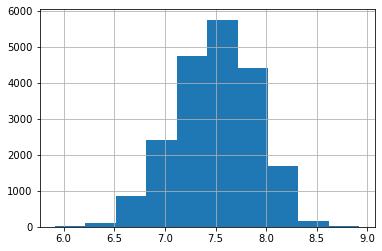

In [16]:
# Model 2

# in order to scale this distribution we will need to perform a log transform 

sqft_scld = np.log(kc['sqft_living'])
sqft_scld.hist()

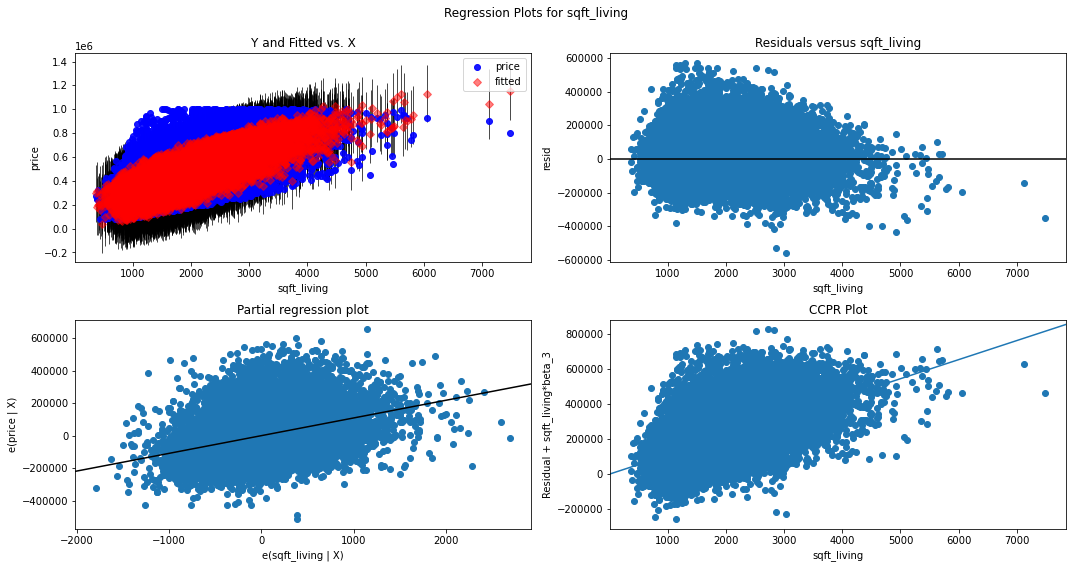

In [17]:
# Model 3

# Visualize terms, specifically sqft_living

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

# the positive correlation in Y and Fitted vs. X graph shows that sqft_living and price are correlated. 
# this is heteroscedastic 

In [18]:
# we will use sqft_living first for analysis since it has the highest correlation in relation to price

model2 = sm.OLS(sqft_scld, kc['sqft_living']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            sqft_living   R-squared (uncentered):                   0.902
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                          1.855e+05
Date:                Wed, 20 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:47:04   Log-Likelihood:                         -45790.
No. Observations:               20137   AIC:                                  9.158e+04
Df Residuals:                   20136   BIC:                                  9.159e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living     0.0034    7.9e-06    430.687      0.000       0.003       0.003
==============================================================================
Omnibus:                     2921.600   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4826.130
Skew:                          -0.984   Prob(JB):                         0.00
Kurtosis:                       4.370   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-19-01ce7b916a78>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


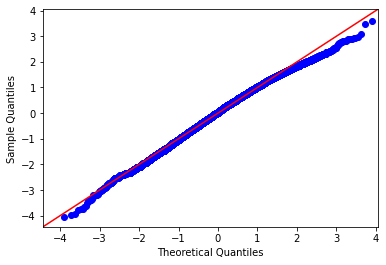

In [19]:
# Q-Q Plot for model 1

residuals = model2.resid
fig = sm.graphics.qqplot(sqft_scld, dist=stats.norm, line='45', fit=True)
fig.show()

#this model is very skewed 

Next we will move on to bathrooms

<AxesSubplot:>

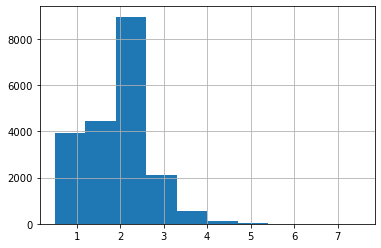

In [20]:
# Bathrooms are more scaled than sqft_living but still does have a skew to the left

kc['bathrooms'].hist()

<AxesSubplot:>

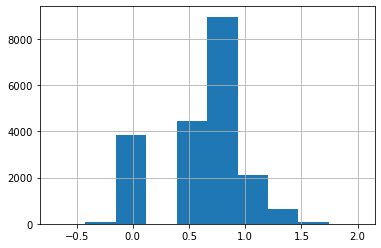

In [21]:
# Log transform bathrooms

bath_scld = np.log(kc['bathrooms'])
bath_scld.hist()

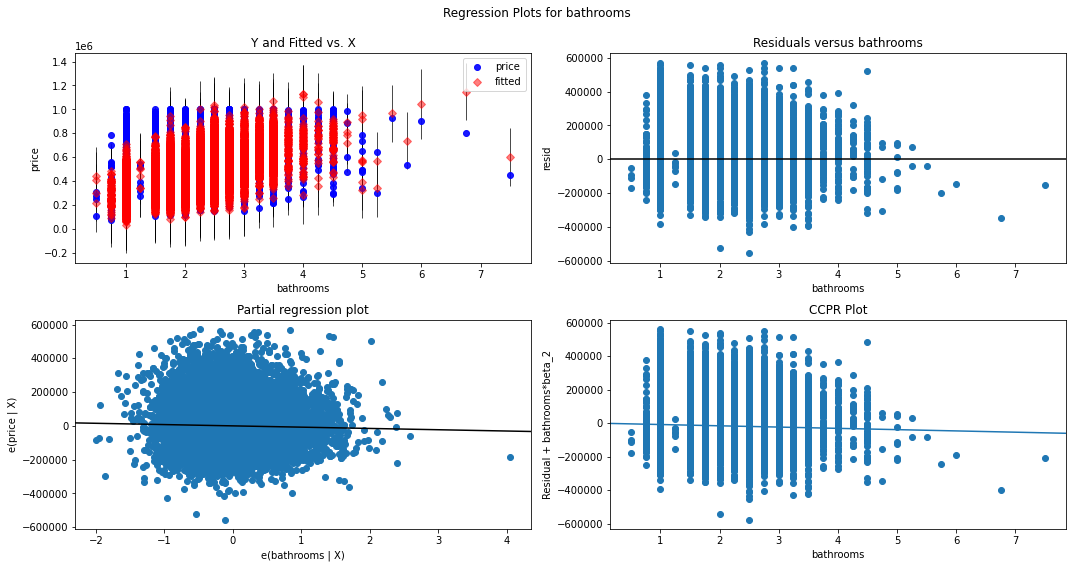

In [22]:
# Visualize terms, specifically bathrooms

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

In [23]:
model3 = sm.OLS(bath_scld, kc['bathrooms']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              bathrooms   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          4.096e+05
Date:                Wed, 20 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:47:06   Log-Likelihood:                          8052.6
No. Observations:               20137   AIC:                                 -1.610e+04
Df Residuals:                   20136   BIC:                                 -1.610e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms      0.3392      0.001    640.032      0.000       0.338       0.340
==============================================================================
Omnibus:                     3240.127   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5126.314
Skew:                          -1.235   Prob(JB):                         0.00
Kurtosis:                       3.072   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-24-bf78ceaa548f>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


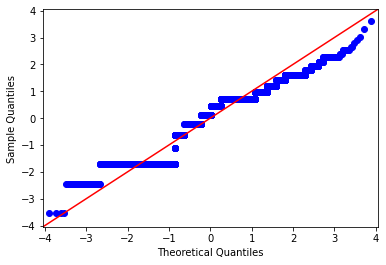

In [24]:
residuals = model3.resid
fig = sm.graphics.qqplot(bath_scld, dist=stats.norm, line='45', fit=True)
fig.show()

In [25]:
# Comparing sqft_living to bathrooms

# need help reading this

data_ols = pd.concat([sqft_scld, bath_scld], axis=1)
data_ols.head()

,sqft_living,bathrooms
0,7.073270,0.000000
1,7.851661,0.810930
2,6.646391,0.000000
3,7.580700,1.098612
4,7.426549,0.693147


In [26]:
bx = 'price~sqft_scld+bath_scld'

model2 = ols(formula=bx, data=kc).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     5280.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:47:06   Log-Likelihood:            -2.6977e+05
No. Observations:               20137   AIC:                         5.395e+05
Df Residuals:                   20134   BIC:                         5.396e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.763e+06   2.96e+04    -59.559      0.000   -1.82e+06   -1.71e+06
sqft_scld   2.978e+05   4208.418     70.771      0.000     2.9e+05    3.06e+05
bath_scld  -5781.5782   4341.857     -1.332      0.183   -1.43e+04    2728.816
==============================================================================
Omnibus:                      656.061   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.343
Skew:                           0.434   Prob(JB):                    2.05e-150
Kurtosis:                       2.740   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluation 

# Conclusion